In [102]:
import pandas as pd
import glob
import math
import contractions
from nltk.corpus import stopwords
from nltk import word_tokenize
import keras
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Input, Conv1D, MaxPooling1D, Flatten, Conv2D, Bidirectional
from keras.utils import plot_model, vis_utils
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import emoji
import string
from keras.callbacks import ModelCheckpoint

# Task 4 improving the models imports
import spacy



In [2]:
# Data has been preprocessed by removing all the " characters: sed -i 's/"//g' *.txt
# as this caused issues reading the data as a csv file. 
# Also had to remove a blank line from subtask A 2016 test data 
# TODO instead change the quote char in the read_csv call

# Load the data
fileGlob = glob.glob('./task3Data/*.txt')

traindf = pd.concat([pd.read_csv(f, sep='\t', header=None, keep_default_na=False) for f in fileGlob], ignore_index = True)
traindf.columns = ['id','topic','label','raw']
#traindf = traindf.drop(['date'], axis=1)

# Things to try:
Convert the text into vector my using a pre-trained system. 
Convert text into a vector by using a NN to train the embeddings. 

Looks like i need to handle the weird character replacement that's happening

In [3]:
# Need to do some preprocessing on the data to remove stop words, punctuation and probably stem the words too. 
# Need to handle the /u002c and other unicdoe character artifacts that are happening. 
# If removing punctuation then may want to simply remove them 
# but if expanding contractinons will need to convert them first. - a library exists to do this
# Need to check to see what's happening with emojis



In [126]:
def preprocess(tweet, stop_words, target):
    # Handle utf8 unicode problems
    #print(tweet)
    #tweet = emoji.demojize(tweet)
    
    tweet = tweet.encode('utf8').decode('unicode_escape', 'ignore') 
    tweet = contractions.fix(tweet)
    tweet = tweet.lower()
    if target.lower() in tweet:
        tweet = tweet.replace(target,"<TARGETTOKEN>")
        
    tweetLine = word_tokenize(tweet)
    # remove all tokens that are not alphabetic or stopwords, also lower the words
    tweetLine = [word for word in tweetLine if word not in stop_words and word not in string.punctuation]
    return tweetLine

stop_words = stopwords.words('english')

traindf['text'] = traindf.apply(lambda row: preprocess(row['raw'], stop_words, row['topic']),axis=1)


/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: invalid escape sequence '\_'
  
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: invalid escape sequence '\m'
  
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: invalid escape sequence '\,'
  
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: invalid escape sequence '\o'
  
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: invalid escape sequence '\l'
  


In [4]:
# Sanity check to ensure tweets are tweet length
maxi = 0
for text in traindf.text:
    length = len(' '.join(text))
    if length > maxi:
        maxi = length
        sanityCheck = text
print(maxi)
print(sanityCheck)

maxi = 0
for text in traindf.text:
    length = len(text)
    if length > maxi:
        maxi = length
        sanityCheck = text
print(maxi)
print(sanityCheck)

165
['TARGETTOKEN', 'systems', 'technical', 'university', 'come', 'visit', 'TARGETTOKEN', 'global', 'training', 'providers', 'TARGETTOKEN', 'stu15', 'TARGETTOKEN', 'training', 'starts', '01/sep', 'http', '//t.co/yntxyrlyod']
39
['work', 'friday', 'night', 'lt', 'lt', 'lt', 'lt', 'lt', 'TARGETTOKEN', 'bound', 'morning', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt', 'gt']


In [5]:
pd.options.display.max_colwidth = 10000
sample = traindf.loc[traindf.id == 641648318754516992]

print(sample.raw.item())
print(sample.text.item())
print(sample.label.item())
print(sample.topic.item())
sampleLine = preprocess(sample.raw.item(),stop_words, sample.topic.item())
print(sampleLine)
print(sample.topic.item() in sample.raw.item().lower())

I can't stop thinking about the fact that I'm going to be in the presence of Snoop Dogg on Sunday
['stop', 'thinking', 'fact', 'going', 'presence', 'TARGETTOKEN', 'sunday']
2
snoop dogg
['stop', 'thinking', 'fact', 'going', 'presence', 'TARGETTOKEN', 'sunday']
True


In [6]:
# create index-word relationship
word2idx = {'<PAD>': 0, '<UNK>' : 1,'TARGETTOKEN' : 2 }
idx2word ={}
sents_as_ids = []
for line in traindf.text:
    sentId = []
    for word in line:
        if word in word2idx:
            sentId.append(word2idx[word])
            continue
        count = len(word2idx)
        word2idx[word] = count
        idx2word[count] = word
        sentId.append(count)
    sents_as_ids.append(sentId)
    

In [7]:
def convertTextToNumSeq(text, word2idx,MAXIMUM_LENGTH):
    numSeq = []
    for word in text:
        if word in word2idx:
            numSeq.append(word2idx[word])
        else:
            # If unseen put in unknown
            numSeq.append(1) 
                
    numSeq = pad_sequences([numSeq],MAXIMUM_LENGTH )
    return numSeq

MAXIMUM_LENGTH = 50 # Motivated because max sequence of words i had was 32

traindf['numSeq'] = traindf.apply(lambda row: convertTextToNumSeq(row['text'], word2idx, MAXIMUM_LENGTH),axis=1)

In [28]:
x_train, x_val, y_train, y_val = train_test_split(traindf.numSeq, traindf.label, stratify=traindf.label, random_state =2)
labelDist = y_val.value_counts()
print(labelDist)
x_train = np.array([x for y in x_train for x in y]).reshape(len(x_train),MAXIMUM_LENGTH)
x_val = np.array([x for y in x_val for x in y]).reshape(len(x_val),MAXIMUM_LENGTH)


labelCount = len(labelDist)
#Y data is categorical therefore must be converted to a vector
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
y_train = onehot_encoder.fit_transform(np.array(y_train).reshape(len(y_train),1))
y_val = onehot_encoder.transform(np.array(y_val).reshape(len(y_val),1))

 0    3248
 1    3230
-1     850
 2     255
-2      75
Name: label, dtype: int64


In [20]:
VOCAB_SIZE = 60000

EMBED_SIZE = 100
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE,input_length=MAXIMUM_LENGTH))
model.add(LSTM(100))

model.add(Dense(labelCount, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
weightsFilePath="task3Weights.best.hdf5"

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           6000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 505       
Total params: 6,080,905
Trainable params: 6,080,905
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Save the best weights to a file so we get the model with the best val acc
checkpoint = ModelCheckpoint(weightsFilePath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit(x_train,y_train,epochs=5,batch_size=128,validation_data=(x_val, y_val), callbacks=[checkpoint],verbose=1)

Train on 22974 samples, validate on 7658 samples
Epoch 1/5
22974/22974 [==============================] - 29s 1ms/step - loss: 1.1272 - acc: 0.4759 - val_loss: 1.0289 - val_acc: 0.5504

Epoch 00001: val_acc improved from -inf to 0.55040, saving model to task3Weights.best.hdf5
Epoch 2/5
22974/22974 [==============================] - 29s 1ms/step - loss: 0.8300 - acc: 0.6672 - val_loss: 1.0087 - val_acc: 0.5615

Epoch 00002: val_acc improved from 0.55040 to 0.56150, saving model to task3Weights.best.hdf5
Epoch 3/5
22974/22974 [==============================] - 29s 1ms/step - loss: 0.4665 - acc: 0.8298 - val_loss: 1.2047 - val_acc: 0.5418

Epoch 00003: val_acc did not improve from 0.56150
Epoch 4/5
22974/22974 [==============================] - 29s 1ms/step - loss: 0.2621 - acc: 0.9079 - val_loss: 1.5104 - val_acc: 0.5257

Epoch 00004: val_acc did not improve from 0.56150
Epoch 5/5
22974/22974 [==============================] - 29s 1ms/step - loss: 0.1631 - acc: 0.9434 - val_loss: 1.8075 

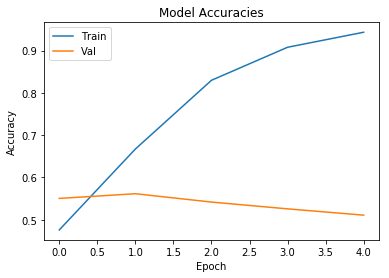

In [12]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'])
plt.show()

In [13]:
# With stop word removal,string.punctuation word removal, vocab size 60000, padding at 50, get 0.56 val accuracy 
# adding in TARGETTOKEN  increased accuracy by less than 1% 

In [35]:
# Load the weights from the model with the best val accuracy
model.load_weights(weightsFilePath)

y_pred = model.predict(x_val)
y_pred = np.array([[1 if i == max(sc) else 0 for i in sc] for sc in y_pred])
y_pred_text = onehot_encoder.inverse_transform(y_pred)
y_val_text = onehot_encoder.inverse_transform(y_val)

NameError: name 'model' is not defined

In [15]:
cm = confusion_matrix(y_val_text, y_pred_text)

In [18]:
def averageFScore(cm):
    (noClasses,_) = cm.shape
    fsum = 0
    recalls = []
    precisions = []
    for i in range(noClasses):
        correct = cm[i][i]
        # if row or col total is zero set to 1 to avoid nans
        rowTotal = max(sum(cm[i]),1)
        colTotal = max(sum(cm[:,i]),1)
        recall = correct / rowTotal
        recalls.append(recall)
        precision = correct / colTotal
        precisions.append(precision)
        
        # Get denominator, if 0 set to 1 to avoid nans
        denominator = precision + recall if precision + recall > 0 else 1
        f1 = 2*precision*recall / denominator
        fsum += f1
    return fsum/noClasses, recalls, precisions

In [42]:
# Rows are the actual, columns are the predicted. strongly negative,  negative, neutral, positve, strongly positive
print(cm)

[[   0   99   58   20    0]
 [   1 1024 1797  723    0]
 [   0  782 3414 1998    0]
 [   0  109  744 1479    0]
 [   0    6   12  113    0]]


In [43]:
valAccuracy = (cm[0][0] + cm[1][1] + cm[2][2] +cm[3][3] + cm[4][4])/sum(sum(cm))
avgfscore, recalls, precisions = averageFScore(cm)
print(f"Average fscore: {avgfscore}")
print(f"valAccuracy {valAccuracy}")
print(f"Recalls for each class: {recalls}")
print(f"Precisions for each class {precisions}")

0.0
0.5069306930693069
0.5666390041493776
0.34133394876528966
0.0
Average fscore: 0.27412543884924134
testAccuracy 0.4779869133209468
Recalls for each class: [0.0, 0.28885754583921014, 0.5511785598966742, 0.6342195540308748, 0.0]
Precisions for each class [0.0, 0.5069306930693069, 0.5666390041493776, 0.34133394876528966, 0.0]


## Performance on test data

In [11]:
# Load the data
testdf = pd.read_csv('./SemEval2017-task4-test/SemEval2017-task4-test.subtask-CE.english.txt', sep='\t', header=None, keep_default_na=False)
testdf.columns = ['id','topic','label','raw']

testdf['text'] = testdf.apply(lambda row: preprocess(row['raw'], stop_words, row['topic']),axis=1)


/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: invalid escape sequence '\ '
  
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: invalid escape sequence '\o'
  
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: invalid escape sequence '\_'
  
/home/leem/anaconda3/envs/eenlp/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: invalid escape sequence '\S'
  


In [107]:
testdf['numSeq'] = testdf.apply(lambda row: convertTextToNumSeq(row['text'], word2idx, MAXIMUM_LENGTH),axis=1)

In [108]:
x_test = testdf['numSeq']
y_test = testdf['label']

# Prelim analysis to indicate class imbalance
print(y_test.value_counts())

# Onehot encode the y data
y_test = onehot_encoder.transform(np.array(y_test).reshape(len(y_test),1))
x_test = np.array([x for y in x_test for x in y]).reshape(len(x_test),MAXIMUM_LENGTH)

 0    6194
-1    3545
 1    2332
-2     177
 2     131
Name: label, dtype: int64


In [21]:
# Get predictions and prepare data for confusion matrix
y_testpred = model.predict(x_test)
y_testpred = np.array([[1 if i == max(sc) else 0 for i in sc] for sc in y_testpred])
y_testpred_text = onehot_encoder.inverse_transform(y_testpred)
y_test_text = onehot_encoder.inverse_transform(y_test)

In [47]:
# Create confusion matrix and get some key information from it. 
cm = confusion_matrix(y_test_text, y_testpred_text, labels=[-2,-1,0,1,2])
print(cm)
testAccuracy = (cm[0][0] + cm[1][1] + cm[2][2] +cm[3][3] + cm[4][4])/sum(sum(cm))
avgfscore, recalls, precisions = averageFScore(cm)
print(f"Average fscore: {avgfscore}")
print(f"testAccuracy {testAccuracy}")
print(f"Recalls for each class: {recalls}")
print(f"Precisions for each class {precisions}")

[[   0   99   58   20    0]
 [   1 1024 1797  723    0]
 [   0  782 3414 1998    0]
 [   0  109  744 1479    0]
 [   0    6   12  113    0]]
Average fscore: 0.27412543884924134
testAccuracy 0.4779869133209468
Recalls for each class: [0.0, 0.28885754583921014, 0.5511785598966742, 0.6342195540308748, 0.0]
Precisions for each class [0.0, 0.5069306930693069, 0.5666390041493776, 0.34133394876528966, 0.0]


Test accuracy was 47.8%, the drop compared to other subtasks is expected as there are more classes for this task, therefore the challenge is harder. Again the average fscore is low because of the poor precision and recall for the extreme cases of strongly negative and strongly positive. The test and trainign data have a large class imbalance which makes this problem harder. Future work could improve the model by addressing the class imbalance. 

# Step 4: Improving the classifier
Steps: try training on all the trainign data
- try training on the training and then doing an additional epoch on the validation set
- try dealing with class imbalance
- try calculating loss and accuracy based on the proximity of the classes to each other
- try a different model usch as a bi-lstm or a cnn
- try other embeddings
- try getting other data

In [132]:
# Using different embeddings
# Spacy embeddings. 

def spacyEmbeddings(wordList, nlp):
    spacyList = []
    for word in wordList:
        spacyList.append(nlp(word).vector)
    return spacyList

# Pads the spacy vec to consistent length
def padSpacy(spacyList, MAXIMUM_LENGTH):
    vecSize = len(spacyList[0])
    listLength = len(spacyList)
    zeroVec = np.zeros(vecSize)
    for i in range(MAXIMUM_LENGTH - listLength):
        spacyList.append(zeroVec)
    return np.array(spacyList)

nlp = spacy.load('en_vectors_web_lg')
traindf['spacy'] = traindf.apply(lambda row: spacyEmbeddings(row['text'], nlp),axis=1)

# Get average vecotor for NBOW model. N.B. Doing this before the padding to avoid diluting signal
traindf['spacyAvg'] = traindf.apply(lambda row: np.average(row['spacy'], axis=0),axis=1)

# Trying to use spacy 300 dim vector as a sequence created objects too big for my laptop's memory

In [133]:
spacy_x_train, spacy_x_val, spacy_y_train, spacy_y_val = train_test_split(traindf.spacyAvg, traindf.label, stratify=traindf.label, random_state =2)
labelDist = spacy_y_val.value_counts()
print(labelDist)
spacy_x_train = np.array([x for y in spacy_x_train for x in y]).reshape(len(spacy_x_train),300)
spacy_x_val = np.array([x for y in spacy_x_val for x in y]).reshape(len(spacy_x_val),300)
print(spacy_x_train[0].shape)

labelCount = len(labelDist)
#Y data is categorical therefore must be converted to a vector
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
spacy_y_train = onehot_encoder.fit_transform(np.array(spacy_y_train).reshape(len(spacy_y_train),1))
spacy_y_val = onehot_encoder.transform(np.array(spacy_y_val).reshape(len(spacy_y_val),1))

 0    3248
 1    3230
-1     850
 2     255
-2      75
Name: label, dtype: int64
(300,)


In [134]:
# This is a NBOW model as it takes the average pacy vector for the sentence and then uses that as an input
spacyModel = Sequential()
spacyModel.add(Dense(64, activation='relu',input_shape=(300,)))
spacyModel.add(Dropout(0.2))
spacyModel.add(Dense(128, activation='relu'))
spacyModel.add(Dropout(0.2))
spacyModel.add(Dense(128, activation='relu'))
spacyModel.add(Dropout(0.2))
spacyModel.add(Dense(64, activation='relu'))
spacyModel.add(Dense(5, activation='softmax'))
spacyModel.summary()

spacyModel.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Save the best weights to a file so we get the model with the best val acc
spacyWeightsFilePath="task3Spacy.best.hdf5"

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 64)                19264     
_________________________________________________________________
dropout_64 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_98 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_65 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_66 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_100 (Dense)            (None, 64)                8256      
__________

In [135]:
spacyCheckpoint = ModelCheckpoint(spacyWeightsFilePath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
spaceyHistory = spacyModel.fit(spacy_x_train, spacy_y_train, epochs=30,batch_size=128,validation_data=(spacy_x_val, spacy_y_val), callbacks=[spacyCheckpoint],verbose=1)

Train on 22974 samples, validate on 7658 samples
Epoch 1/30
22974/22974 [==============================] - 5s 236us/step - loss: 1.0827 - acc: 0.5094 - val_loss: 0.9729 - val_acc: 0.5713

Epoch 00001: val_acc improved from -inf to 0.57130, saving model to task3Spacy.best.hdf5
Epoch 2/30
22974/22974 [==============================] - 1s 40us/step - loss: 0.9662 - acc: 0.5621 - val_loss: 0.9427 - val_acc: 0.5806

Epoch 00002: val_acc improved from 0.57130 to 0.58057, saving model to task3Spacy.best.hdf5
Epoch 3/30
22974/22974 [==============================] - 1s 28us/step - loss: 0.9444 - acc: 0.5772 - val_loss: 0.9459 - val_acc: 0.5832

Epoch 00003: val_acc improved from 0.58057 to 0.58318, saving model to task3Spacy.best.hdf5
Epoch 4/30
22974/22974 [==============================] - 1s 30us/step - loss: 0.9281 - acc: 0.5846 - val_loss: 0.9346 - val_acc: 0.5793

Epoch 00004: val_acc did not improve from 0.58318
Epoch 5/30
22974/22974 [==============================] - 1s 29us/step - lo

In [137]:
spacy_y_test = testdf['label']
spacy_y_test = onehot_encoder.transform(np.array(spacy_y_test).reshape(len(spacy_y_test),1))

testdf['spacy'] = testdf.apply(lambda row: spacyEmbeddings(row['text'], nlp),axis=1)

# Get average vecotor for NBOW model. N.B. Doing this before the padding to avoid diluting signal
testdf['spacyAvg'] = testdf.apply(lambda row: np.average(row['spacy'], axis=0),axis=1)

spacy_x_test = testdf['spacyAvg']
spacy_x_test = np.array([x for y in spacy_x_test for x in y]).reshape(len(spacy_x_test),300)



In [138]:
# Load the weights from the model with the best val accuracy
spacyModel.load_weights(spacyWeightsFilePath)

# Get predictions and prepare data for confusion matrix
spacy_y_testpred = spacyModel.predict(spacy_x_test)
spacy_y_testpred = np.array([[1 if i == max(sc) else 0 for i in sc] for sc in spacy_y_testpred])
spacy_y_testpred_text = onehot_encoder.inverse_transform(spacy_y_testpred)
spacy_y_test_text = onehot_encoder.inverse_transform(spacy_y_test)

In [139]:
# Create confusion matrix and get some key information from it. 
cm = confusion_matrix(spacy_y_test_text, spacy_y_testpred_text, labels=[-2,-1,0,1,2])
print(cm)
testAccuracy = (cm[0][0] + cm[1][1] + cm[2][2] +cm[3][3] + cm[4][4])/sum(sum(cm))
avgfscore, recalls, precisions = averageFScore(cm)
print(f"Average fscore: {avgfscore}")
print(f"testAccuracy {testAccuracy}")
print(f"Recalls for each class: {recalls}")
print(f"Precisions for each class {precisions}")

[[   0  128   45    4    0]
 [   0 1385 1980  180    0]
 [   0  684 4797  713    0]
 [   0   90 1097 1145    0]
 [   0    2   11  118    0]]
Average fscore: 0.3327734799848806
testAccuracy 0.5918894902657726
Recalls for each class: [0.0, 0.3906911142454161, 0.7744591540200194, 0.49099485420240135, 0.0]
Precisions for each class [0.0, 0.6050677151594582, 0.6049180327868853, 0.5300925925925926, 0.0]


Spacy NBOW method gets 58.3% validation accuracy and 59.2% test accuracy. This performance is similar to the LSTM at validation but outperforms the LSTM for test accuracy and test fscore. I believe the test performance improvement is largely due to the large number of dropout layers, which help defend against overfitting. This has made the Spacy NBOW model more robust than the LSTM. The Spacy NBOW model also takes much less time to train so might be more useful for real world applications that may require fast training/processing. Multiple architectures were experimented with before settling on this architecture, including much deeper networks, much wider networks, networks without dropout.

## Step 4: Alternative model2: CNN
In this I try a CNN model to see if that can improve the accuracy using learnt embeddings

In [98]:
# Perform transfer learning to transfer weights learnt from original model to accelerate learning
model.load_weights(weightsFilePath)
embeddingLayer = model.get_layer(index=0)
embeddingLayer.trainable=False # Massively Reduce number of trainable weights which may help reduce overfitting
cnnModel = Sequential()
cnnModel.add(embeddingLayer)
cnnModel.add(Conv1D(64, 3))
cnnModel.add(Dropout(0.5))
cnnModel.add(MaxPooling1D(3))
cnnModel.add(Flatten())
cnnModel.add(Dense(128, activation='relu'))
cnnModel.add(Dropout(0.5))
cnnModel.add(Dense(64, activation='relu'))
cnnModel.add(Dense(5, activation='softmax'))
cnnModel.summary()

cnnModel.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



# Save the best weights to a file so we get the model with the best val acc
cnnWeightsFilePath="task3CNN.best.hdf5"

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           6000000   
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 48, 64)            19264     
_________________________________________________________________
dropout_52 (Dropout)         (None, 48, 64)            0         
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 16, 64)            0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_78 (Dense)             (None, 128)               131200    
_________________________________________________________________
dropout_53 (Dropout)         (None, 128)               0         
__________

In [99]:
cnnCheckpoint = ModelCheckpoint(cnnWeightsFilePath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
cnnHistory = cnnModel.fit(x_train, y_train, epochs=20,batch_size=128,validation_data=(x_val, y_val), callbacks=[cnnCheckpoint],verbose=1)

Train on 22974 samples, validate on 7658 samples
Epoch 1/20
22974/22974 [==============================] - 5s 199us/step - loss: 0.7192 - acc: 0.7354 - val_loss: 1.1024 - val_acc: 0.5569

Epoch 00001: val_acc improved from -inf to 0.55693, saving model to task3CNN.best.hdf5
Epoch 2/20
22974/22974 [==============================] - 2s 89us/step - loss: 0.4884 - acc: 0.8336 - val_loss: 1.1838 - val_acc: 0.5437

Epoch 00002: val_acc did not improve from 0.55693
Epoch 3/20
22974/22974 [==============================] - 2s 89us/step - loss: 0.4490 - acc: 0.8423 - val_loss: 1.1553 - val_acc: 0.5526

Epoch 00003: val_acc did not improve from 0.55693
Epoch 4/20
22974/22974 [==============================] - 2s 90us/step - loss: 0.4242 - acc: 0.8491 - val_loss: 1.1402 - val_acc: 0.5477

Epoch 00004: val_acc did not improve from 0.55693
Epoch 5/20
22974/22974 [==============================] - 2s 92us/step - loss: 0.4076 - acc: 0.8581 - val_loss: 1.2775 - val_acc: 0.5424

Epoch 00005: val_acc di

Main issue with the CNN has been overfitting, Adding dropout layers and maxpooling has not helped. Architectures that used multiple conv layers to reduce the trainable dimensions also did not help. There is a ~20% diff between training and val accuracies from the start and that only increases as training continues. Experiments with different architectures and with non-trainable vs trainable embeddings did not yield signifcant improvements. The best validation accuracy was 55.7%. This is not much lower than the LSTM and is much faster to train, the overfitting remains its main challenge. 

## Step4: Model 3: Bidirectional LSTM

In [103]:
bilstmModel = Sequential()
bilstmModel.add(Embedding(VOCAB_SIZE, EMBED_SIZE,input_length=MAXIMUM_LENGTH))
bilstmModel.add(Bidirectional(LSTM(128)))
bilstmModel.add(Dropout(0.5))
bilstmModel.add(Dense(labelCount, activation='softmax'))
bilstmModel.summary()

bilstmModel.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
bilstmWeightsFilePath="task3bilstm.best.hdf5"



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           6000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               234496    
_________________________________________________________________
dropout_54 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 5)                 1285      
Total params: 6,235,781
Trainable params: 6,235,781
Non-trainable params: 0
_________________________________________________________________


In [104]:
# Save the best weights to a file so we get the model with the best val acc
bilstmCheckpoint = ModelCheckpoint(bilstmWeightsFilePath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
bilstmHistory = bilstmModel.fit(x_train,y_train,epochs=5,batch_size=128,validation_data=(x_val, y_val), callbacks=[bilstmCheckpoint],verbose=1)

Train on 22974 samples, validate on 7658 samples
Epoch 1/5
22974/22974 [==============================] - 37s 2ms/step - loss: 1.1134 - acc: 0.4895 - val_loss: 0.9889 - val_acc: 0.5652

Epoch 00001: val_acc improved from -inf to 0.56516, saving model to task3bilstm.best.hdf5
Epoch 2/5
22974/22974 [==============================] - 32s 1ms/step - loss: 0.8131 - acc: 0.6768 - val_loss: 1.0127 - val_acc: 0.5602

Epoch 00002: val_acc did not improve from 0.56516
Epoch 3/5
22974/22974 [==============================] - 33s 1ms/step - loss: 0.4912 - acc: 0.8221 - val_loss: 1.1658 - val_acc: 0.5410

Epoch 00003: val_acc did not improve from 0.56516
Epoch 4/5
22974/22974 [==============================] - 32s 1ms/step - loss: 0.2957 - acc: 0.8960 - val_loss: 1.5823 - val_acc: 0.5290

Epoch 00004: val_acc did not improve from 0.56516
Epoch 5/5
22974/22974 [==============================] - 32s 1ms/step - loss: 0.1950 - acc: 0.9311 - val_loss: 1.8731 - val_acc: 0.5141

Epoch 00005: val_acc did n

In [111]:
# Load the weights from the model with the best val accuracy
bilstmModel.load_weights(bilstmWeightsFilePath)

bilstm_y_test_pred = bilstmModel.predict(x_test)
bilstm_y_test_pred = np.array([[1 if i == max(sc) else 0 for i in sc] for sc in bilstm_y_test_pred])
bilstm_y_test_pred_text = onehot_encoder.inverse_transform(bilstm_y_test_pred)
y_test_text = onehot_encoder.inverse_transform(y_test)

In [112]:
# Create confusion matrix and get some key information from it. 
cm = confusion_matrix(y_test_text, bilstm_y_test_pred_text, labels=[-2,-1,0,1,2])
print(cm)
testAccuracy = (cm[0][0] + cm[1][1] + cm[2][2] +cm[3][3] + cm[4][4])/sum(sum(cm))
avgfscore, recalls, precisions = averageFScore(cm)
print(f"Average fscore: {avgfscore}")
print(f"testAccuracy {testAccuracy}")
print(f"Recalls for each class: {recalls}")
print(f"Precisions for each class {precisions}")

[[   0   38  115   24    0]
 [   0  423 2585  537    0]
 [   0  389 4494 1311    0]
 [   0   18 1092 1222    0]
 [   0    0   21  110    0]]
Average fscore: 0.2505999266948812
testAccuracy 0.495920510542047
Recalls for each class: [0.0, 0.11932299012693935, 0.7255408459799806, 0.5240137221269296, 0.0]
Precisions for each class [0.0, 0.4873271889400922, 0.5409895269050199, 0.381398252184769, 0.0]


The bidirectional LSTM makes only a small improvement on the LSTM. It has a validation accuracy of 56.5% but a test accuracy of 49.6%. The NBOW remains the strongest model despite it using only the average word vector, meaning it ignores the sequences of words. 